# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [114]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import os
import acquire
import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module.

In [115]:
#acquire.scrape_github_data()

In [116]:
df = pd.read_json('data.json')

In [117]:
df.head()

,language,readme_contents,repo
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freeCodeCamp/freeCodeCamp
1,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,996icu/996.ICU
2,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",vuejs/vue
3,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,facebook/react
4,C++,"<div align=""center"">\n <img src=""https://www....",tensorflow/tensorflow


## II. Prep

`prep_articles` function from the prepare.py module performs the following:
 - normalize data by removing non-ascii characters, special characters, numbers, white spaces...
 - tokenize words
 - stem and lemmatize words
 - remove stop words and other extraneous words

In [118]:
df = prepare.prep_articles(df)
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner https amaz...,freecodecamp org social banner http amazonaw c...,freecodecamp org social banner http amazonaws ...,freecodecamp social amazonaws freecodecamp wid...
1,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,icu https icu please not...,icu http icu pleas note that there exist other...,icu http icu please note that there exists oth...,please note exists official account app mercha...
2,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",align center href https vuejs org targ...,align center href http vuej org target blank r...,align center href http vuejs org target blank ...,align center vuejs target blank rel noopener n...
3,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,react https reactjs org middot githu...,react http reactj org middot github licens htt...,react http reactjs org middot github license h...,react reactjs middot license shield badge lice...
4,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src https www te...,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,align center tensorflow social documentation d...


What are the words we want to exclude?
- http
- banner
- request
- img
- badge
- svg
- www
- com
- png
- welcome
- pr
- style
- flat
- makeapullrequest
- gitpod
- logo
- blue
- green
- brightgreen
- div
- align
- center
- width
- src

Look for documents where there are no programming language indicated.

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
language      79 non-null object
original      90 non-null object
normalized    90 non-null object
stemmed       90 non-null object
lemmatized    90 non-null object
cleaned       90 non-null object
dtypes: object(6)
memory usage: 4.3+ KB


In [120]:
df[df.language.isnull()]

,language,original,normalized,stemmed,lemmatized,cleaned
6,None,This page is available as an easy-to-read webs...,this page available easy read website ht...,thi page avail easi read websit http ebookfoun...,this page available easy read website http ebo...,page available easy read website ebookfoundati...
7,None,"<div align=""center"">\n\t<img width=""500"" heigh...",div align center img width height ...,div align center img width height src media lo...,div align center img width height src medium l...,align center width height medium svg alt aweso...
8,None,# You Don't Know JS Yet (book series) - 2nd Ed...,you don know yet book series edition ...,you don know yet book seri edit thi seri book ...,you don know yet book series edition this seri...,know yet book series edition series book divin...
10,None,# Coding Interview University\n\n> I originall...,coding interview university originally cre...,code interview univers origin creat thi short ...,coding interview university originally created...,coding interview university originally created...
11,None,# A collection of `.gitignore` templates\n\nTh...,collection gitignore templates this gith...,collect gitignor templat thi github collect gi...,collection gitignore template this githubs col...,collection gitignore template githubs collecti...
12,None,![Web Developer Roadmap - 2019](https://i.imgu...,web developer roadmap https imgur c...,web develop roadmap http imgur com ccv png roa...,web developer roadmap http imgur com ccv png r...,web developer roadmap imgur ccv roadmap becomi...
28,None,🌍\n*[Čeština](README-cs.md) ∙ [Deutsch](README...,cestina readme deutsch readme re...,cestina readm deutsch readm readm english read...,cestina readme deutsch readme readme english r...,cestina readme deutsch readme readme english r...
35,None,免费的编程中文书籍索引\n============================\n\n[...,https img shields github issues justjavac f...,http img shield github issu justjavac free pro...,http img shield github issue justjavac free pr...,shield issue justjavac free programming book s...
41,None,**[[Submit tutorial](https://github.com/danist...,submit tutorial https github com danistefan...,submit tutori http github com danistefanov bui...,submit tutorial http github com danistefanovic...,submit tutorial danistefanovic build issue new...
53,None,![Open Source Society University (OSSU)](http:...,open source society university ossu http ...,open sourc societi univers ossu http imgur com...,open source society university ossu http imgur...,open source society university ossu imgur kyyc...


Since the programming language is necessary to train the model, we will drop these documents from our data set.

In [121]:
df = df[df.language.notnull()]

## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

In [122]:
dfx = df[["language","cleaned"]]

In [123]:
dfx.head()

,language,cleaned
0,JavaScript,freecodecamp social amazonaws freecodecamp wid...
1,Rust,please note exists official account app mercha...
2,JavaScript,align center vuejs target blank rel noopener n...
3,JavaScript,react reactjs middot license shield badge lice...
4,C++,align center tensorflow social documentation d...


### Look at Lengths of README files by Language

In [124]:
df_len = dfx.assign(length = dfx.cleaned.apply(len))

In [125]:
df_len.head()

,language,cleaned,length
0,JavaScript,freecodecamp social amazonaws freecodecamp wid...,7080
1,Rust,please note exists official account app mercha...,3952
2,JavaScript,align center vuejs target blank rel noopener n...,10357
3,JavaScript,react reactjs middot license shield badge lice...,3341
4,C++,align center tensorflow social documentation d...,7652


In [126]:
df_len[df_len['language'] == 'JavaScript']

,language,cleaned,length
0,JavaScript,freecodecamp social amazonaws freecodecamp wid...,7080
2,JavaScript,align center vuejs target blank rel noopener n...,10357
3,JavaScript,react reactjs middot license shield badge lice...,3341
5,JavaScript,align center getbootstrap getbootstrap doc ass...,7705
13,JavaScript,airbnb javascript style guide mostly reasonabl...,72361
14,JavaScript,data driven document svg align left hspace vsp...,1260
18,JavaScript,align center facebook react native react nativ...,4761
23,JavaScript,create react app build status dev azure facebo...,6261
25,JavaScript,axios npm version shield npm axios svg style f...,13787
29,JavaScript,align center nodejs alt node nodejs static lig...,14082


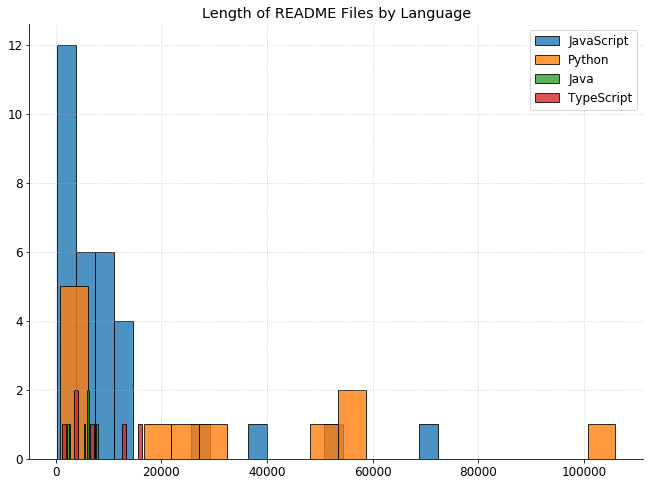

In [127]:
bins = 20
plt.hist(df_len[df_len['language'] == 'JavaScript']['length'], bins=bins, alpha=0.8, label='JavaScript')
plt.hist(df_len[df_len['language'] == 'Python']['length'], bins=bins, alpha=0.8, label='Python')
plt.hist(df_len[df_len['language'] == 'Java']['length'], bins=bins, alpha=0.8, label='Java')
plt.hist(df_len[df_len['language'] == 'TypeScript']['length'], bins=bins, alpha=0.8, label='TypeScript')

plt.legend()
plt.title('Length of README Files by Language')
plt.show()

#### A. Distribution of Data, Top Words

In [128]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,32
Python,12
Java,6
TypeScript,6
C++,4
Go,4
Vue,2
C,2
PHP,1
Rust,1


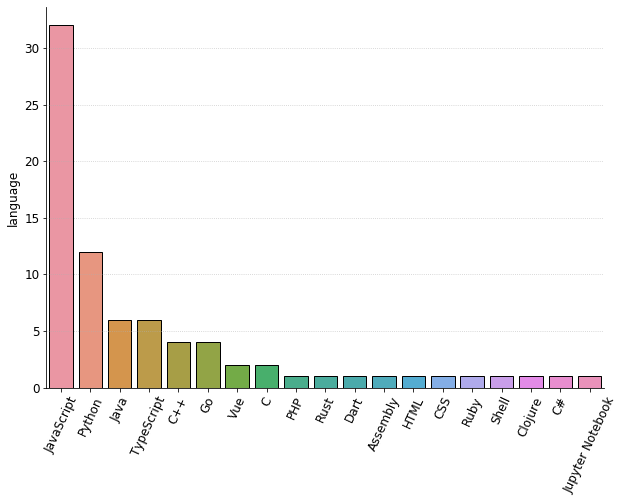

In [129]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.show()

#### Value Counts and Percentages for Language

In [56]:
pd.concat(
    [dfx.language.value_counts(), dfx.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,32,0.405063
Python,12,0.151899
Java,6,0.075949
TypeScript,6,0.075949
C++,4,0.050633
Go,4,0.050633
Vue,2,0.025316
C,2,0.025316
PHP,1,0.012658
Rust,1,0.012658


### Term Frequency

In [61]:
raw_count_js = pd.Series(' '.join(df[df.language=='JavaScript']['cleaned']).split()).value_counts()
raw_count_p = pd.Series(' '.join(df[df.language=='Python']['cleaned']).split()).value_counts()
raw_count_j = pd.Series(' '.join(df[df.language=='Java']['cleaned']).split()).value_counts()
raw_count_ts = pd.Series(' '.join(df[df.language=='TypeScript']['cleaned']).split()).value_counts()

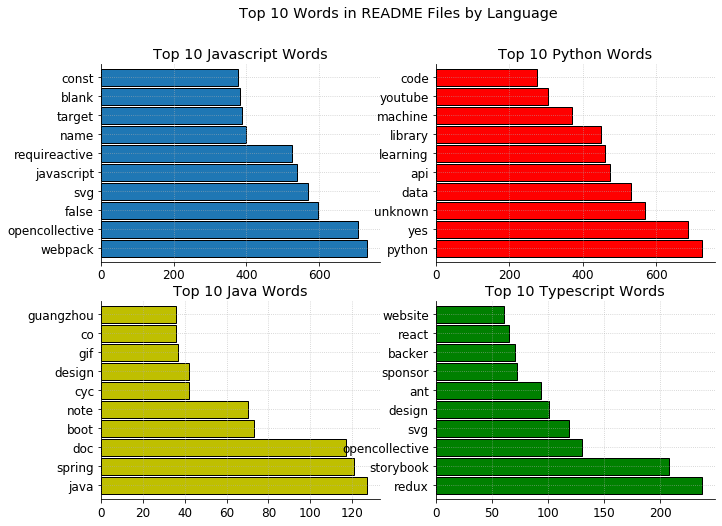

In [86]:
subplot(2,2,1)
raw_count_js.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Javascript Words')

subplot(2,2,2)
raw_count_p.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Python Words')

subplot(2,2,3)
raw_count_j.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 Java Words')

subplot(2,2,4)
raw_count_ts.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 Typescript Words')

suptitle('Top 10 Words in README Files by Language')

plt.show()

In [88]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

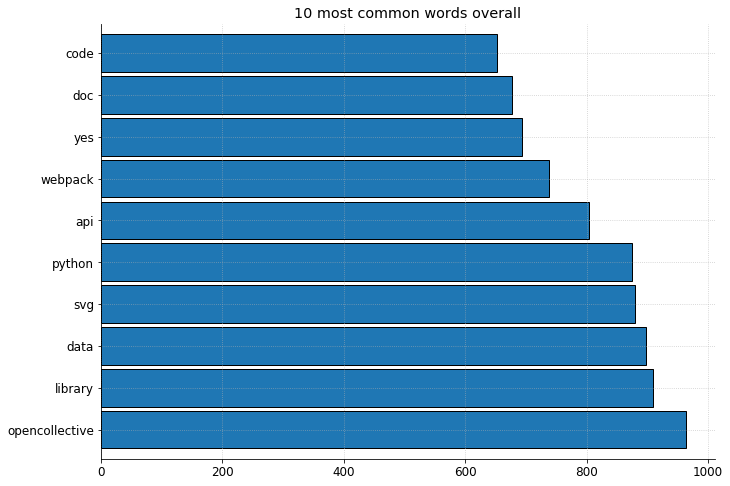

In [87]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words overall')

plt.show()

### Frequency of Words by Language Subsets

In [95]:
js_words = ' '.join(dfx[dfx.language == 'JavaScript'].cleaned).split()
js_words

['freecodecamp',
 'social',
 'amazonaws',
 'freecodecamp',
 'wide',
 'social',
 'pull',
 'shield',
 'badge',
 'pr',
 'brightgreen',
 'svg',
 'style',
 'flat',
 'makeapullrequest',
 'first',
 'timer',
 'friendly',
 'shield',
 'badge',
 'first',
 'timer',
 'friendly',
 'blue',
 'svg',
 'firsttimersonly',
 'open',
 'source',
 'helper',
 'codetriage',
 'freecodecamp',
 'freecodecamp',
 'badge',
 'user',
 'svg',
 'codetriage',
 'freecodecamp',
 'freecodecamp',
 'setup',
 'automated',
 'shield',
 'badge',
 'setup',
 'automated',
 'blue',
 'gitpod',
 'gitpod',
 'referrer',
 'freecodecamp',
 'open',
 'source',
 'codebase',
 'curriculum',
 'freecodecamp',
 'freecodecamp',
 'friendly',
 'community',
 'learn',
 'code',
 'free',
 'run',
 'donor',
 'supported',
 'nonprofit',
 'donate',
 'freecodecamp',
 'help',
 'million',
 'busy',
 'adult',
 'transition',
 'tech',
 'community',
 'ha',
 'already',
 'helped',
 'people',
 'get',
 'first',
 'developer',
 'job',
 'full',
 'stack',
 'web',
 'development

In [96]:
p_words = ' '.join(dfx[dfx.language == 'Python'].cleaned).split()
p_words

['english',
 'readme',
 'readme',
 'readme',
 'han',
 'readme',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'portugues',
 'brasil',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'deutsch',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'italiano',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'polski',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'espanol',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'turkce',
 'donnemartin',
 'system',
 'design',
 'primer',
 'issue',
 'tieng',
 'viet',
 'donne

In [97]:
j_words = ' '.join(dfx[dfx.language == 'Java'].cleaned).split()
j_words

['align',
 'center',
 'gitstar',
 'ranking',
 'repository',
 'badgen',
 'net',
 'badge',
 'rank',
 'icon',
 'color',
 'asset',
 'download',
 'badgen',
 'net',
 'badge',
 'ovo',
 'icon',
 'telegram',
 'color',
 'cyc',
 'note',
 'badgen',
 'net',
 'badge',
 'cyc',
 'icon',
 'sourcegraph',
 'color',
 'badgen',
 'net',
 'badge',
 'cyc',
 'icon',
 'r',
 'color',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'java',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'nbsp',
 'pencil',
 'pencil',
 'computer',
 'computer',
 'cloud',
 'cloud',
 'art',
 'art',
 'floppy',
 'disk',
 'floppy',
 'disk',
 'coffee',
 'coffee',
 'java',
 'bulb',
 'bulb',
 'wrench',
 'wrench',
 'watermelon',
 'watermelon',
 'memo',
 'memo',
 'align',
 'center',
 'note',
 'co',
 'guangzhou',
 'myqcloud',
 'githubio',
 'logomakr',
 'zpezn',
 'width',
 'pencil',
 'offer',
 'cyc',
 'note',
 'blob

In [98]:
ts_words = ' '.join(dfx[dfx.language == 'TypeScript'].cleaned).split()
ts_words

['visual',
 'studio',
 'code',
 'open',
 'source',
 'code',
 'os',
 'build',
 'status',
 'dev',
 'azure',
 'vscode',
 'vscode',
 'apis',
 'build',
 'status',
 'code',
 'branchname',
 'master',
 'aka',
 'vscode',
 'build',
 'build',
 'status',
 'dev',
 'azure',
 'vscode',
 'vscode',
 'apis',
 'build',
 'status',
 'code',
 'branchname',
 'master',
 'dev',
 'azure',
 'vscode',
 'vscode',
 'build',
 'latest',
 'definitionid',
 'feature',
 'shield',
 'issue',
 'microsoft',
 'vscode',
 'feature',
 'svg',
 'microsoft',
 'vscode',
 'issue',
 'aopen',
 'aissue',
 'label',
 'afeature',
 'sort',
 'areactions',
 'desc',
 'bug',
 'shield',
 'issue',
 'microsoft',
 'vscode',
 'bug',
 'svg',
 'microsoft',
 'vscode',
 'issue',
 'utf',
 'aissue',
 'aopen',
 'label',
 'abug',
 'gitter',
 'shield',
 'badge',
 'chat',
 'gitter',
 'yellow',
 'svg',
 'gitter',
 'microsoft',
 'vscode',
 'repository',
 'repository',
 'code',
 'os',
 'microsoft',
 'develop',
 'visual',
 'studio',
 'code',
 'code',
 'visualstud

In [105]:
all_words = ' '.join(dfx.cleaned).split()
all_words

['freecodecamp',
 'social',
 'amazonaws',
 'freecodecamp',
 'wide',
 'social',
 'pull',
 'shield',
 'badge',
 'pr',
 'brightgreen',
 'svg',
 'style',
 'flat',
 'makeapullrequest',
 'first',
 'timer',
 'friendly',
 'shield',
 'badge',
 'first',
 'timer',
 'friendly',
 'blue',
 'svg',
 'firsttimersonly',
 'open',
 'source',
 'helper',
 'codetriage',
 'freecodecamp',
 'freecodecamp',
 'badge',
 'user',
 'svg',
 'codetriage',
 'freecodecamp',
 'freecodecamp',
 'setup',
 'automated',
 'shield',
 'badge',
 'setup',
 'automated',
 'blue',
 'gitpod',
 'gitpod',
 'referrer',
 'freecodecamp',
 'open',
 'source',
 'codebase',
 'curriculum',
 'freecodecamp',
 'freecodecamp',
 'friendly',
 'community',
 'learn',
 'code',
 'free',
 'run',
 'donor',
 'supported',
 'nonprofit',
 'donate',
 'freecodecamp',
 'help',
 'million',
 'busy',
 'adult',
 'transition',
 'tech',
 'community',
 'ha',
 'already',
 'helped',
 'people',
 'get',
 'first',
 'developer',
 'job',
 'full',
 'stack',
 'web',
 'development

### Explore Frequency of Subsets by Language

In [100]:
js_freq = pd.Series(js_words).value_counts()

In [101]:
p_freq = pd.Series(p_words).value_counts()

In [102]:
j_freq = pd.Series(j_words).value_counts()

In [103]:
ts_freq = pd.Series(ts_words).value_counts()

In [107]:
all_freq = pd.Series(all_words).value_counts()

### Combine Series' together into df

In [108]:
word_counts = (pd.concat([all_freq, js_freq, p_freq, j_freq, ts_freq], axis=1, sort=True)
 .set_axis(['all', 'javascript', 'python', 'java', 'typescript'], axis=1, inplace=False)
 .fillna(0)
 .apply(lambda s: s.astype(int)))

word_counts.head()

,all,javascript,python,java,typescript
aaa,1,0,0,0,0
aac,5,2,2,0,0
aaction,1,0,1,0,0
aadc,1,0,0,1,0
aaef,1,0,0,1,0


### Most Frequently Occuring Words

In [109]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,java,typescript
opencollective,963,708,1,0,130
library,910,56,448,1,7
data,897,237,531,16,8
svg,880,570,30,11,119
python,875,2,723,0,0
api,804,131,474,9,6
webpack,738,731,0,0,7
yes,693,1,687,0,1
doc,677,237,176,117,27
code,652,159,275,9,47


### Explore Words Unique to Languages

#### Python Keywords

In [112]:
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False)

,all,javascript,python,java,typescript
unknown,570,0,570,0,0
ndash,178,0,177,0,0
httpie,151,0,151,0,0
neural,135,0,124,0,0
oauth,122,0,105,0,0
kera,94,0,94,0,0
natural,103,0,93,0,0
nlp,84,0,76,0,0
cran,74,0,74,0,0
tensorflow,229,0,72,0,0


#### Javascript Keywords

In [113]:
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False)


,all,javascript,python,java,typescript
webpack,738,731,0,0,7
requireactive,524,524,0,0,0
blank,509,381,0,1,60
backer,429,293,0,0,71
eslint,211,209,0,0,2
reveal,192,192,0,0,0
puppeteer,166,166,0,0,0
vue,201,139,0,0,6
vuejs,130,124,0,0,0
axios,121,118,0,0,0


### Create Corpus

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [120]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

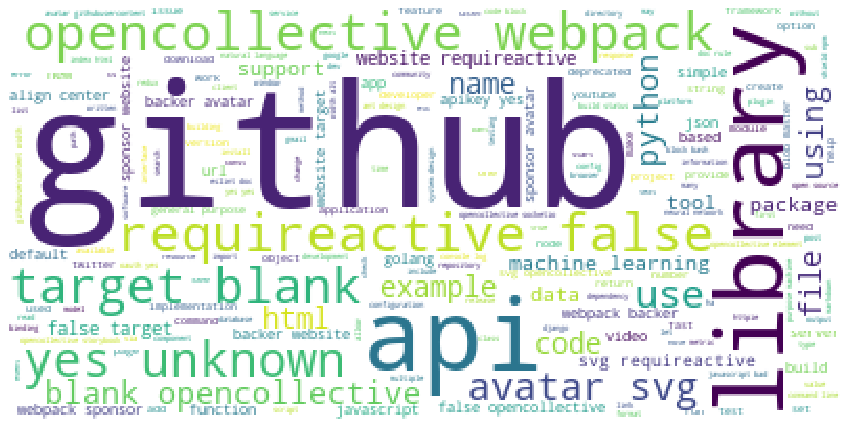

In [121]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

### C. Common Bigrams